# Flower Speices Image Classifier

This notebook contains the code for the model I am going to deploy tp my mobile app. I'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below.

<img src='assets/Flowers.png' width=500px>

The model creation is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

In [ ]:
!pip install onnx
!pip install onnx_tf
!pip install onnx2keras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for onnx2keras: filename=onnx2keras-0.0.24-py3-none-any.whl size=24577 sha256=692753a888577383be04e8a4cb4be97505e6e9b49da8811a58a1743fdb745733
  Stored in directory: /root/.cache/pip/wheels/a1/fb/c9/349c27912022d104c7dd5f5d272595c33b1b959c4468d5e784
Successfully built onnx2keras


In [2]:
# Imports here
import numpy as np
from google.colab import drive
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns
import PIL
import json
import time
from torch.utils.mobile_optimizer import optimize_for_mobile
import onnx
import torchvision
import onnx_tf
from onnx2keras import onnx_to_keras
from onnx import helper
import tensorflow as tf
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

C:\Users\Abdelrahman\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Load the data

Here I'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise it can be [downloaded here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, I'll apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. I'll also make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this I won't use any scaling or rotation transformations, but I'll need to resize then crop the images to the appropriate size.

The pre-trained networks I'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets I'll normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.


In [ ]:
# get data from google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# getting the data
data_dir = '/content/drive/MyDrive/flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
# setting the means and standard deviations
means = [0.485, 0.456, 0.406]
std_dev = [0.229, 0.224, 0.225]

In [ ]:
# Define the transforms for the training, validation, and testing sets
# images in the training set are randomely rotated, cropped, and horizontally flipped unlike the validation and test sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(means,
                                                            std_dev)])

# no need to perform randomization on validation/test samples; only need to normalize
valid_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(means,
                                                            std_dev)])

test_transforms  = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(means,
                                                            std_dev)])

# Load the datasets with ImageFolder
train_datasets = datasets.ImageFolder(train_dir, transform = train_transforms)
valid_datasets = datasets.ImageFolder(valid_dir, transform = valid_transforms)
test_datasets  = datasets.ImageFolder(test_dir,  transform = test_transforms)

# Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size = 64, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_datasets, batch_size = 64)
test_loader  = torch.utils.data.DataLoader(test_datasets,  batch_size = 64)

### Label mapping

I'll load in a mapping from category label to category name. This in included in the file `cat_to_name.json`. It's a JSON object which be can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give us a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [ ]:
# make a way to turn category numbers into flower names
with open('/content/drive/MyDrive/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. I will use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

Things I'll do in this section:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters


In [ ]:
# the model of choice is vgg16. a research found that it generalizes very well without needing a high number of epochs
# research link: http://www.jatit.org/volumes/Vol99No2/3Vol99No2.pdf
model = models.vgg16(pretrained = True)
# freezing our feature parameters
for param in model.parameters():
    param.requires_grad = False
# print model information
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 120MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
#checking the shape of our data
dataiter = iter(train_loader)
images,labels = next(dataiter)
print(images.shape)

torch.Size([64, 3, 224, 224])


In [ ]:
# here we define our classifier. it has 2 hidden layers, and a dropout value of 0.5 which works the best with hidden networks
classifier = nn.Sequential(OrderedDict([('hidden_1', nn.Linear(25088, 4096)),
                                         ('dropout', nn.Dropout(p=0.5)),
                                         ('relu_1', nn.ReLU()),
                                         ('hidden_2', nn.Linear(4096,102)),
                                         ('output', nn.LogSoftmax(dim = 1))]))
# changing the classifier in the original model to our classifier above
model.classifier = classifier
criterion = nn.NLLLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

In [ ]:
# use the gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# move the model to our preferred device
model.to(device)
# set the number of epochs
epochs = 30
# this will help us print data every 10 loops
print_every = 10
# overall training loss
training_loss = 0
# loop counter
steps = 0
# validation and training loss history
val_losses = []
train_losses = []
# validation and testing accuracy history
val_accuracy_h = []
test_accuracy_h = []

for epoch in range(epochs):
    for images, labels in train_loader:
        # move the images and labels to our preferred device
        images, labels = images.to(device), labels.to(device)
        # increment the loop counter by one
        steps+= 1
        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()
        # forward propagation to get the probabilities on the log scale
        log_ps = model.forward(images)
        # calculate the loss
        loss = criterion(log_ps, labels)
        # backward propagation
        loss.backward()
        # take a step to lower the loss
        optimizer.step()
        # add the computed loss to the total tarianing loss
        training_loss += loss.item()
        train_losses.append(loss.item())

        # if 10 loops have passed:
        if steps % print_every == 0:
            # set the model to evaluation mode
            model.eval()
            # prediction accuracy
            accuracy = 0
            # loss on the validation set
            valid_loss = 0
            # turn off the gradient because we are testing
            with torch.no_grad():
                # forward propagate, calculate the loss and prediction accuracy
                for images, labels in valid_loader:
                    images, labels = images.to(device), labels.to(device)

                    log_ps = model.forward(images)
                    batch_loss = criterion(log_ps, labels)
                    valid_loss += batch_loss.item()
                    valid_losses.append(batch_loss.item())
                    # calculte accuracy
                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    val_accuracy_h.append(torch.mean(equals.type(torch.FloatTensor)).item())
            # print the results as the network trains
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {training_loss/print_every:.3f}.. "
                  f"validation loss: {valid_loss/len(valid_loader):.3f}.. "
                  f"validation accuracy: {accuracy/len(valid_loader):.3f}")
            # set the training loss to zero again
            training_loss = 0
            # set the model to training mode
            model.train();

Epoch 1/30.. Train loss: 4.341.. validation loss: 3.692.. validation accuracy: 0.259
Epoch 1/30.. Train loss: 3.755.. validation loss: 3.032.. validation accuracy: 0.385
Epoch 1/30.. Train loss: 3.258.. validation loss: 2.464.. validation accuracy: 0.496
Epoch 1/30.. Train loss: 2.729.. validation loss: 1.995.. validation accuracy: 0.573
Epoch 1/30.. Train loss: 2.528.. validation loss: 1.740.. validation accuracy: 0.593
Epoch 1/30.. Train loss: 2.106.. validation loss: 1.351.. validation accuracy: 0.704
Epoch 1/30.. Train loss: 1.931.. validation loss: 1.208.. validation accuracy: 0.735
Epoch 1/30.. Train loss: 1.832.. validation loss: 1.037.. validation accuracy: 0.761
Epoch 1/30.. Train loss: 1.620.. validation loss: 0.910.. validation accuracy: 0.791
Epoch 1/30.. Train loss: 1.559.. validation loss: 0.860.. validation accuracy: 0.793
Epoch 2/30.. Train loss: 1.325.. validation loss: 0.790.. validation accuracy: 0.821
Epoch 2/30.. Train loss: 1.299.. validation loss: 0.760.. validat

## Testing your network

It's good practice to test the trained network on test data, images the network has never seen either in training or validation. This will give us a good estimate for the model's performance on completely new images. I will run the test images through the network and measure the accuracy.

In [ ]:
# Doing validation on the test set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);
accuracy = 0
test_loss = 0
with torch.no_grad():
    model.eval();
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        log_ps = model(images)

        # calculte accuracy
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        test_accuracy_h.append(torch.mean(equals.type(torch.FloatTensor)).item())
    print(f"Test accuracy: {accuracy/len(test_loader):.3f}")


Test accuracy: 0.932


In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation and Testing Acuuracy")
plt.plot(val_accuracy_h,label="val")
plt.plot(test_accuracy_h,label="test")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Save the checkpoint

Now that the network is trained, I will save the model so I can load it later for making predictions.

In [ ]:
# The parameters for PyTorch networks are stored in a model's state_dict.
# We can see the state dict contains the weight and bias matrices for each of our layers.
print("Our model: \n\n", model, '\n')

Our model: 

 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding

In [ ]:
# Save the checkpoint
# mapping of classes to indices
model.class_to_idx = train_datasets.class_to_idx
# information about our network
checkpoint = {'transfer_model': 'vgg16',
              'input_size': 25088,
              'output_size': 102,
              'epochs': 15,
              'features': model.features,
              'classifier': model.classifier,
              'optimizer': optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'class_to_index': model.class_to_idx
             }

torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint


In [ ]:
# Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(path):

    """
    this function takes a path as its input and returns a model saved at the soecified path
    """

    # load network information
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    model = models.vgg16(pretrained = True)
    classifier = nn.Sequential(OrderedDict([('hidden_1', nn.Linear(25088, 4096)),
                                         ('dropout', nn.Dropout(p=0.5)),
                                         ('relu_1', nn.ReLU()),
                                         ('hidden_2', nn.Linear(4096,102)),
                                         ('output', nn.LogSoftmax(dim = 1))]))
    model.classifier = classifier
    for params in model.parameters():
        params.requires_grad = False
    model.class_to_idx = checkpoint['class_to_index']
    model.load_state_dict(checkpoint['state_dict'], strict = False)
    return model


model = load_checkpoint("checkpoint.pth")
device = torch.device("cpu")
model.to(device);

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Inference for classification

Now I'll write a function to use a trained network for inference. It that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities.

First I'll need to handle processing the input image such that it can be used in the network.

## Image Preprocessing

I'll use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)).

First, I will resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then I'll crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. I will need to convert the values. It's easiest with a Numpy array, which we can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. I'll need to subtract the means from each color channel, then divide by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. we can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [ ]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    # Process a PIL image for use in a PyTorch model
    image = PIL.Image.open(image)
    transform = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])
    np_image = np.array(transform(image))

    return np_image

## Checking that the function works properly

<Axes: >

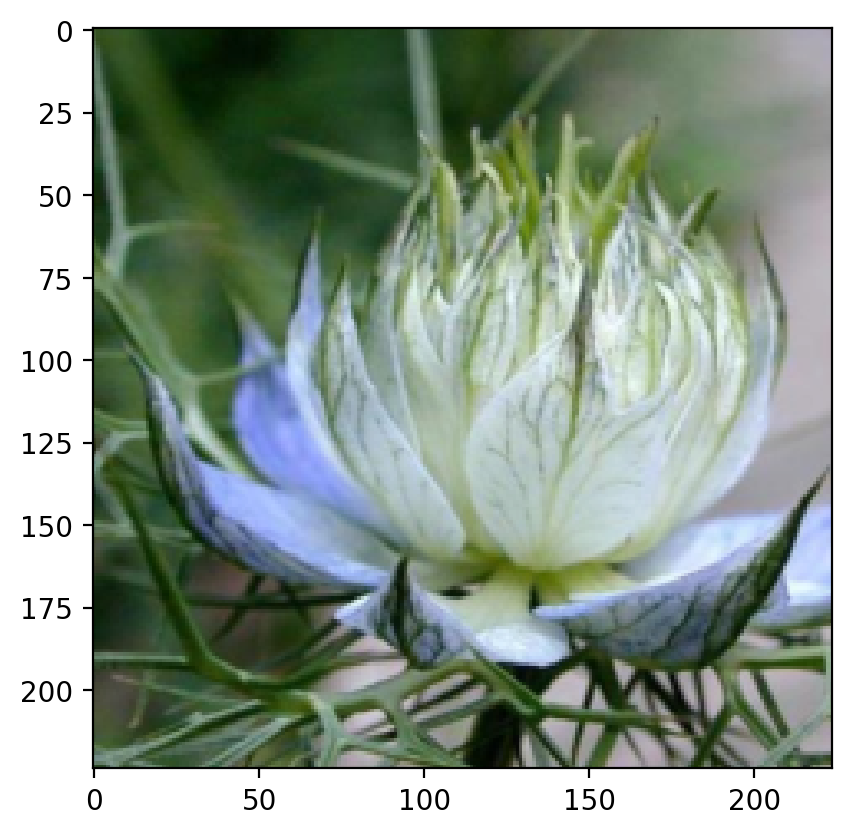

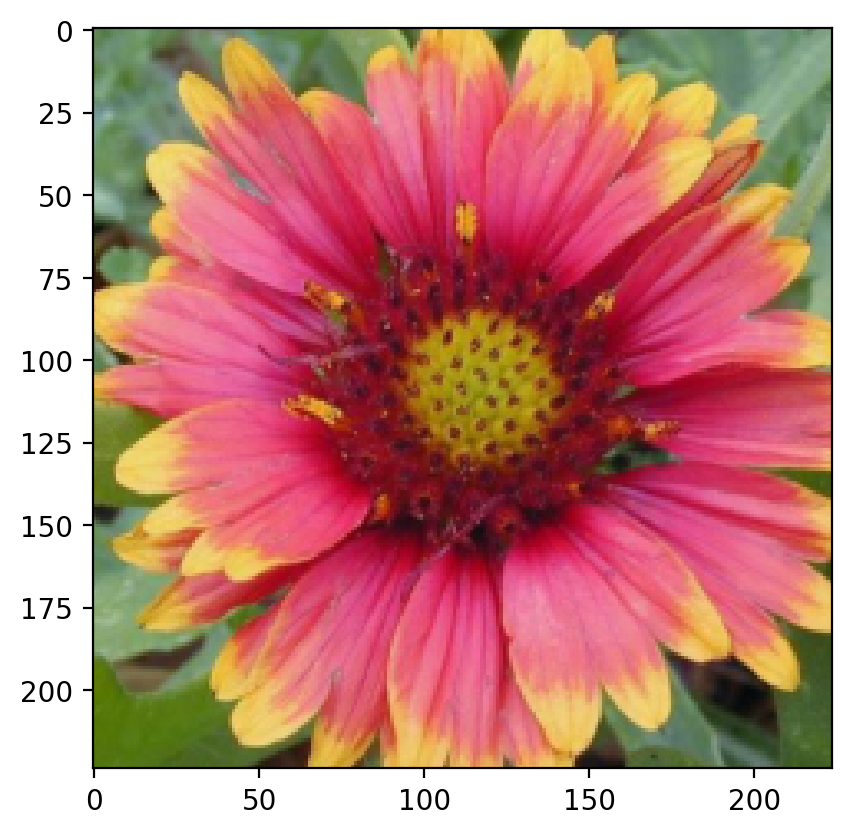

In [ ]:
def imshow(image, ax=None, title=None):
    #img for tensor
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

imshow(process_image("/content/drive/MyDrive/flowers/test/33/image_06454.jpg"))
imshow(process_image("/content/drive/MyDrive/flowers/test/100/image_07897.jpg"))

## Class Prediction

In this section I will write a function to predict the top 5 classes that the flower belongs to.

To get the top $K$ largest values in a tensor I will use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. I will convert from these indices to the actual class labels using `class_to_idx`.

In [ ]:
# Implement the code to predict the class from an image file
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''

    # turn off gradient becuase we are not training
    with torch.no_grad():
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        # process the image
        image = process_image(image_path)
        # convert image into tensor
        image = torch.from_numpy(image)
        # Returns a new tensor with a dimension of size one inserted at the specified position
        image.unsqueeze_(0)
        # convert the image into float
        image = image.float()
        # enter evaluation mode
        model.eval();
        # run the image through the network
        outputs = model(image.to(device))
        # get the top probaabilities and classes
        probs, classes_p = torch.exp(outputs).topk(topk)
        # turn probabilities into lists
        probs = probs.tolist()[0]
        # turn categories into lists
        classes_p = classes_p.tolist()[0]
        # convert from these indices to the actual class labels
        index = {value: key for key, value in model.class_to_idx.items()}
        classes = [index[i] for i in classes_p]
        #Returns the tensors as a (nested) list/ matrix
        return probs, classes

predict('/content/drive/MyDrive/flowers/test/33/image_06454.jpg',model)


([0.998436689376831,
  0.0006949094822630286,
  0.0004617642262019217,
  0.0002195576234953478,
  3.694207043736242e-05],
 ['33', '38', '1', '67', '9'])

## Sanity Checking

In this section I will make sure that the results make sense and that the model behaves as expected. I will use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>


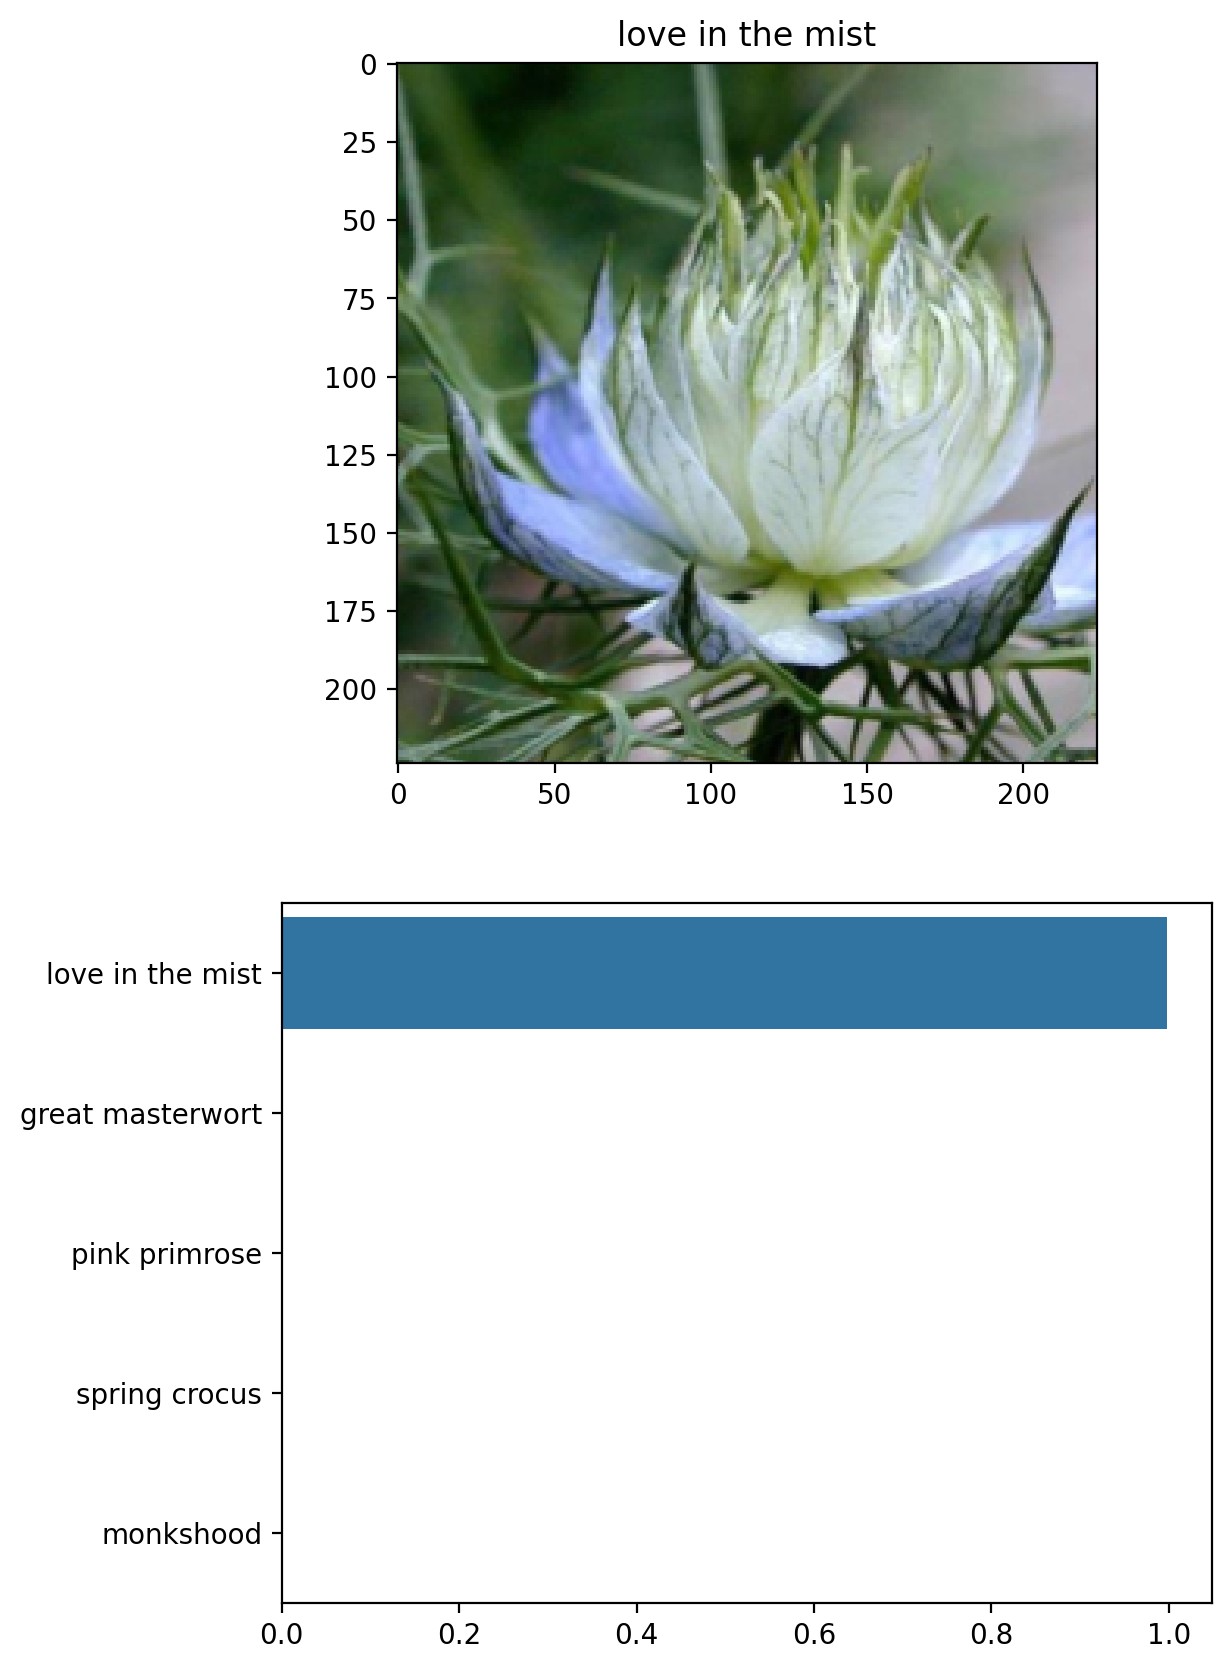

In [ ]:
# Display an image along with the top 5 classes
# specify the image path
image_path = '/content/drive/MyDrive/flowers/test/33/image_06454.jpg'

# Set up the plot
plt.figure(figsize = (6,10))
ax = plt.subplot(2,1,1)

# set the title of the image to the flower name
flower_label = image_path.split('/')[6]
flower_name = cat_to_name[str(flower_label)]
ax.set_title(str(flower_name))

# get the top classes and names
top_p, top_class = predict(image_path,model)
flower_types= [cat_to_name[str(classes)] for classes in top_class]

# Plot flower
img = process_image(image_path)
imshow(img, ax);


# Plot bar chart
plt.subplot(2,1,2)
sns.barplot(x=top_p, y=flower_types, color=sns.color_palette()[0]);
plt.show()

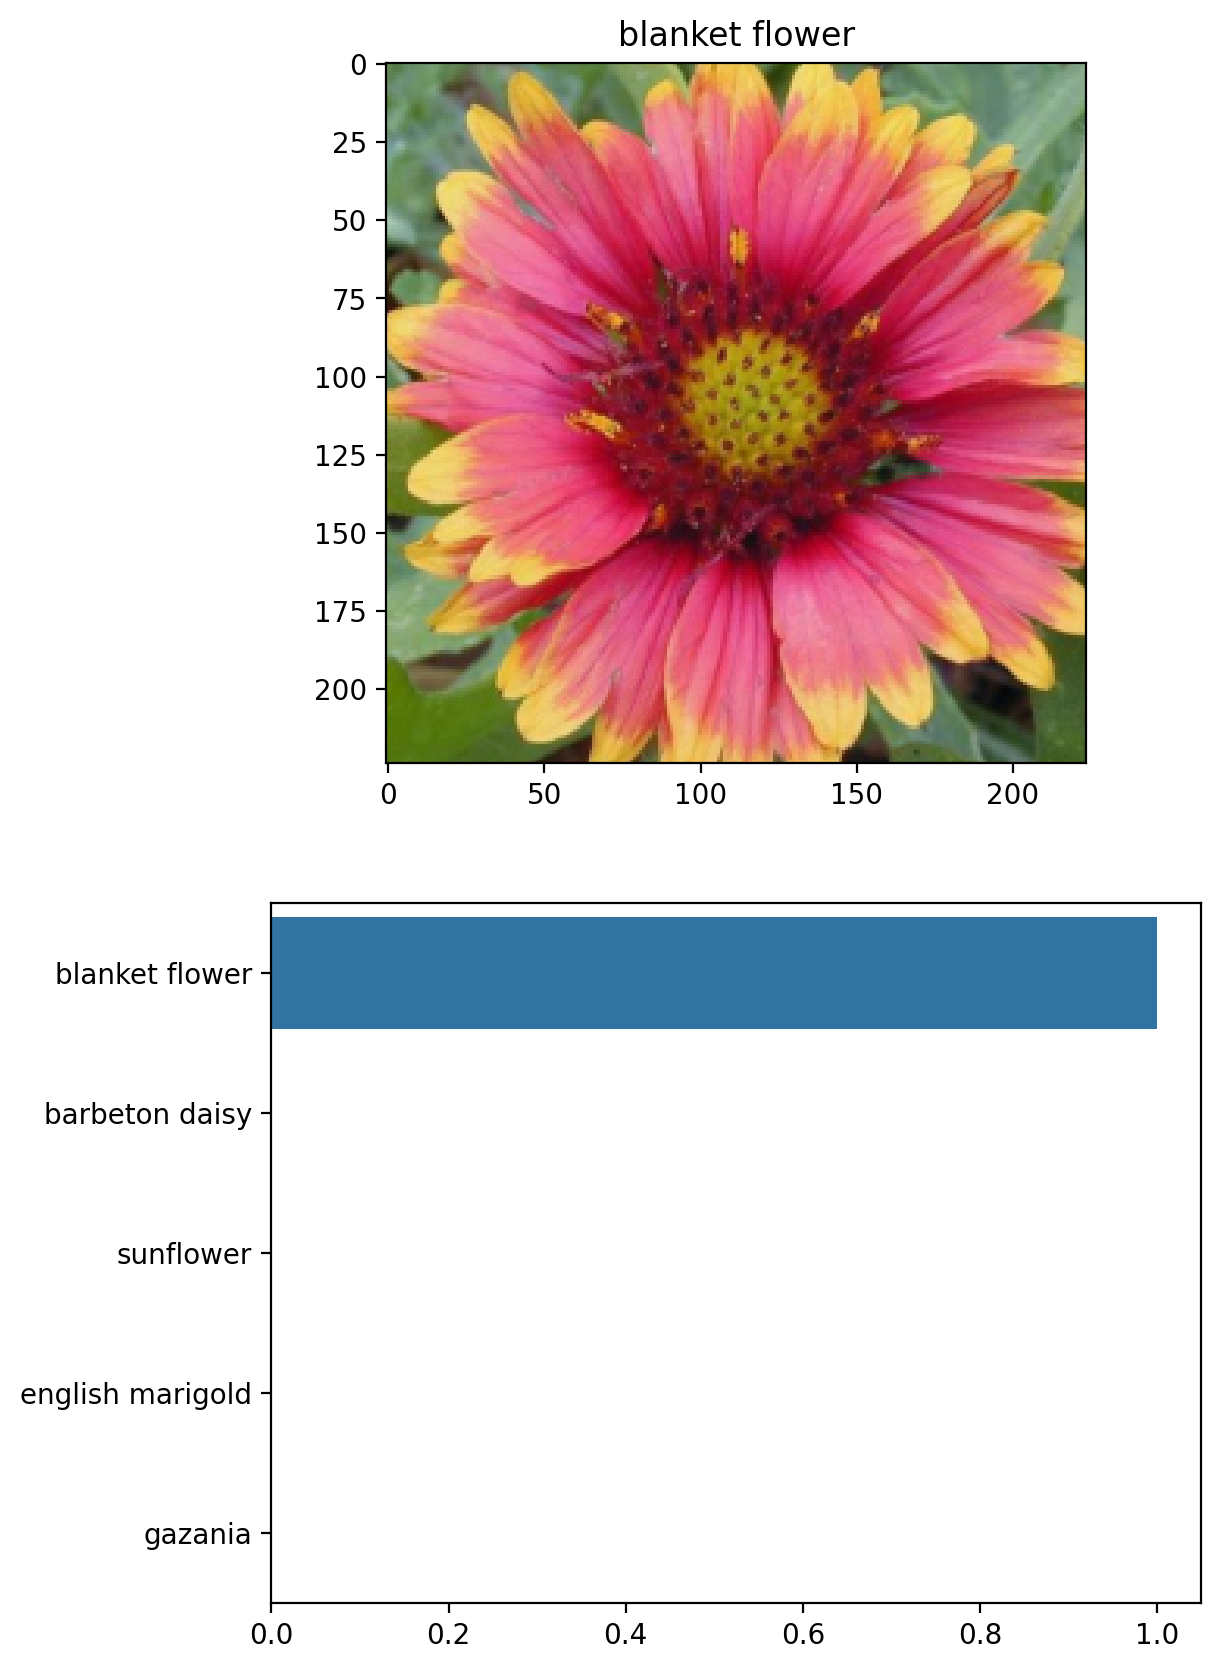

In [ ]:
# specify the image path
image_path = "/content/drive/MyDrive/flowers/test/100/image_07897.jpg"
# Set up the plot
plt.figure(figsize = (6,10))
ax = plt.subplot(2,1,1)

# set the title of the image to the flower name
flower_label = image_path.split("/")[6]
flower_name = cat_to_name[flower_label]
ax.set_title(flower_name)

# get the top classes and names
top_p, top_class = predict(image_path, model)
flower_types = [cat_to_name[str(classes)] for classes in top_class]

# Plot flower
image = process_image(image_path)
imshow(image, ax)

# Plot bar chart
plt.subplot(2,1,2)
sns.barplot(x = top_p, y = flower_types, color = sns.color_palette()[0]);
plt.show()

## Preparing the model to be used in Android Studio
In this section I will convert the model to TorchScript to run on mobile devices.
There are multiple things to be done so that the model can be converted successfully:
1. It must be a subclass of `torch.nn.Module`
2. The forward function input should be Torchscript compatible. As well as all the operations performed inside the function.

In [ ]:
scripted_module = torch.jit.script(model)
optimized_scripted_module = optimize_for_mobile(scripted_module)

# using optimized lite interpreter model makes inference about 60% faster than the non-optimized lite interpreter model, which is about 6% faster than the non-optimized full jit model
optimized_scripted_module._save_for_lite_interpreter("my_model_lite.ptl")

### Convert the model to tflite for more options

In [ ]:
dataiter = iter(train_loader)
images,labels = next(dataiter)
input_shape = images.shape
device = torch.device("cpu")
model.to(device)
torch.onnx.export(model, torch.randn(input_shape), 'Flower Classifier onnx.onnx', opset_version=11)

In [ ]:
onnx_model = onnx.load('Flower Classifier onnx.onnx')
# Define a mapping from old names to new names
name_map = {"input.1": "input_1"}

# Initialize a list to hold the new inputs
new_inputs = []

# Iterate over the inputs and change their names if needed
for inp in onnx_model.graph.input:
    if inp.name in name_map:
        # Create a new ValueInfoProto with the new name
        new_inp = helper.make_tensor_value_info(name_map[inp.name],
                                                inp.type.tensor_type.elem_type,
                                                [dim.dim_value for dim in inp.type.tensor_type.shape.dim])
        new_inputs.append(new_inp)
    else:
        new_inputs.append(inp)

# Clear the old inputs and add the new ones
onnx_model.graph.ClearField("input")
onnx_model.graph.input.extend(new_inputs)

# Go through all nodes in the model and replace the old input name with the new one
for node in onnx_model.graph.node:
    for i, input_name in enumerate(node.input):
        if input_name in name_map:
            node.input[i] = name_map[input_name]

# Save the renamed ONNX model
onnx.save(onnx_model, 'Flower Classifier-onnx.onnx')

In [ ]:
# Convert ONNX model to TensorFlow format
tf_model = onnx_tf.backend.prepare(onnx_model)
# Export  TensorFlow  model
tf_model.export_graph("Flower Classifier tf.tf")

INFO:absl:Function `__call__` contains input name(s) x, y with unsupported characters which will be renamed to transpose_52_x, mul_1_y in the SavedModel.
INFO:absl:Found untraced functions such as gen_tensor_dict while saving (showing 1 of 1). These functions will not be directly callable after loading.
INFO:absl:Writing fingerprint to Flower Classifier tf.tf/fingerprint.pb


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("Flower Classifier tf.tf")
tflite_model = converter.convert()
open('Flower Classifier tflite.tflite', 'wb').write(tflite_model)

471601024